# unsplash.com에서 이미지 다운로드

In [ ]:
import requests

access_key = 'API KEY'  
url = 'https://api.unsplash.com/search/photos'
query = 'happy dog' # 검색어
total_images = 30 # 다운받을 총 이미지 개수
collected_images = [] 
page = 1 #크롤링 시작 페이지 
per_page = 15  # 페이지당 가져올 이미지 수 (최대 30)

while len(collected_images) < total_images:
    params = {
        'query': query,
        'client_id': access_key,
        'page': page,
        'per_page': per_page
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    if response.status_code == 200 and 'results' in data:
        results = data['results']
        
        for result in results:
            collected_images.append(result['urls']['regular'])
            if len(collected_images) >= total_images:
                break
        
        page += 1  
    else:
        print("Error:", response.status_code, response.text)
        break


# unsplash.com에서 이미지 다운로드 후 폴더에 저장

In [ ]:
import requests
import os

access_key = 'API KEY'
url = 'https://api.unsplash.com/search/photos'
query = 'happy dog' # 검색어
total_images = 200 # 다운받을 총 이미지 개수
collected_images = []
page = 1 # 크롤링 시작 페이지
per_page = 15  # 페이지당 가져올 이미지 수 (최대 30)

folder_path = r"C:\happy dog"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

while len(collected_images) < total_images:
    params = {
        'query': query,
        'client_id': access_key,
        'page': page,
        'per_page': per_page
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    if response.status_code == 200 and 'results' in data:
        results = data['results']
        
        for result in results:
            collected_images.append(result['urls']['regular'])
            if len(collected_images) >= total_images:
                break
        
        page += 1 
    else:
        print("Error:", response.status_code, response.text)
        break

for i, image_url in enumerate(collected_images):
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # 요청에 에러가 있으면 예외 발생
        
        file_path = os.path.join(folder_path, f"happy_dog_{i + 1}.jpg")
        
        with open(file_path, 'wb') as file:
            file.write(response.content)
        
        print(f"Image {i + 1} downloaded and saved as {file_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download image {i + 1}: {e}")

print("All images downloaded.")


# yolo 이용해서 강아지 부분만 crop

In [ ]:
import os
from ultralytics import YOLO
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def crop_dog(input_folder,output_folder):

  model = YOLO('yolov8n.pt')

  input_folder = input_folder
  output_folder = output_folder
  os.makedirs(output_folder, exist_ok=True)

  dog_class_id = 16
  cropped_images = []

  for image_name in os.listdir(input_folder):
      if image_name.endswith('.jpg'):
          image_path = os.path.join(input_folder, image_name)

          results = model(image_path)
          img = Image.open(image_path)
          width, height = img.size
          draw = ImageDraw.Draw(img, 'RGBA')

          for result in results:
              result = result.cpu()
              xyxys = result.boxes.xyxyn
              confs = result.boxes.conf
              clss = result.boxes.cls

              xyxys = xyxys.numpy()
              clss = map(int, clss.numpy())

              for i, (xyxy, conf, cls) in enumerate(zip(xyxys, confs, clss)):
                  if cls == dog_class_id:

                      bbox = [int(xyxy[0]*width), int(xyxy[1]*height), int(xyxy[2]*width), int(xyxy[3]*height)]

                      cropped_img = img.crop(bbox)

                      cropped_image_name = f"{os.path.splitext(image_name)[0]}_crop_{i+1}.jpg"
                      cropped_image_path = os.path.join(output_folder, cropped_image_name)
                      cropped_img.save(cropped_image_path)
                      cropped_images.append(cropped_img)

# crop 결과 중복된 이미지 제거

![스크린샷 2025-07-08 002703.png](<attachment:스크린샷 2025-07-08 002703.png>)
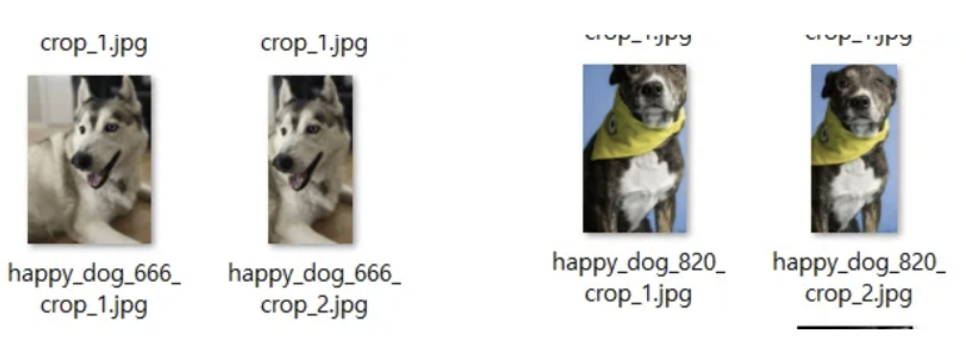

In [ ]:
import re

def erase_duplicate_images(folder_path):
    
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    image_dict = {}

    for image_file in image_files:
        match = re.match(r"(.*)_crop_(\d+)\.jpg", image_file)
        if match:
            base_name = match.group(1)
            crop_number = int(match.group(2))

            if base_name not in image_dict or crop_number < image_dict[base_name][1]:
                image_dict[base_name] = (image_file, crop_number)

    images_to_keep = {value[0] for value in image_dict.values()}
    images_to_delete = [f for f in image_files if f not in images_to_keep]

    for image_file in images_to_delete:
        os.remove(os.path.join(folder_path, image_file))

    print(f"삭제 완료! 남겨진 파일 수: {len(images_to_keep)}")